# Constructing a Model to Predict the Winner Of NBA Games

## Overview

We are building a predictive model using NBA regular season data from the past **4 full seasons**. These seasons should each contain exactly **1,230 games**, based on the standard NBA schedule:

- **30 teams**
- **82 games per team**

We will **confirm this count** for each season to ensure we are pulling **only NBA regular season games** and not mistakenly including:

- G-League games  
- Summer League games  
- Preseason games  

Season Selection:

- 2021–2022
- 2022–2023
- 2023–2024
- 2024–2025

Model Input Features: A simplified set of **six predictive variables**:

1. **Offensive Rating**  
2. **Defensive Rating**  
3. **Pace**  
4. **Number of Days of Rest** (since last game)
5. **A Calculated Form of an Injury Variable**
6. **Home Team Advantage**

These features will be derived using a **rolling average** over the team’s **last 5 games**.

Limitations:

- This model **will only partially account for real-time injury reports** or **last-minute lineup changes**.
- Long-term injuries may be partially captured via rolling averages, but the model will not directly "see" who is playing.
- The trade-off for simplicity is **limited adaptability** to breaking news or in-game substitutions.

Data Filtering Steps (Summary):

1. Pull only **regular season NBA games** from the API.
2. Confirm that each season has **exactly 1,230 games**.
3. Join team statistics (offensive/defensive rating, pace) with each matchup.
4. Calculate **5-game rolling averages** for each team prior to every game.
5. Incorporate other variables like **rest days** and **Home team Advantage** 

---

Once these data checks and filters are in place, we can confidently move on to building the predictive model.


## Import Dependencies & Set Options

In [2]:
# Data Handling
import pandas as pd
import json
from collections import defaultdict
import numpy as np

# Time & Date Utilities
import time
from datetime import datetime, timedelta

# Web Requests
import requests
import os

# Progress Bars
from tqdm import tqdm

# NBA API
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder, teamgamelog, boxscoreusagev2
from nba_api.stats.library.http import NBAStatsHTTP
from nba_api.stats.library.parameters import LeagueID, StartPeriod, EndPeriod

In [3]:
## Set Options
pd.set_option('display.max_columns', None)

## Pre Data Cleaning Steps

### Examine NBA API Endpoints (Skip unless interested)

#### scoreboardv2

In [ ]:
# NBA headers (bypass NBA stats request blocking)
headers = {
    "User-Agent": "Mozilla/5.0",
    "Referer": "https://www.nba.com",
    "x-nba-stats-origin": "stats",
    "x-nba-stats-token": "true"
}

# Set the game date (format: MM/DD/YYYY)
sample_date = '2/25/2025'

# API URL and parameters
url = "https://stats.nba.com/stats/scoreboardv2"
params = {
    "GameDate": sample_date,
    "LeagueID": "00",
    "DayOffset": "0"
}

# Request and parse response
response = requests.get(url, headers=headers, params=params, timeout=10)
data = response.json()

# Loop through all result sets and print column names
for dataset in data['resultSets']:
    name = dataset['name']
    headers = dataset['headers']
    print(f"\n{name} Columns:")
    print(headers)



GameHeader Columns:
['GAME_DATE_EST', 'GAME_SEQUENCE', 'GAME_ID', 'GAME_STATUS_ID', 'GAME_STATUS_TEXT', 'GAMECODE', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'LIVE_PERIOD', 'LIVE_PC_TIME', 'NATL_TV_BROADCASTER_ABBREVIATION', 'HOME_TV_BROADCASTER_ABBREVIATION', 'AWAY_TV_BROADCASTER_ABBREVIATION', 'LIVE_PERIOD_TIME_BCAST', 'ARENA_NAME', 'WH_STATUS', 'WNBA_COMMISSIONER_FLAG']

LineScore Columns:
['GAME_DATE_EST', 'GAME_SEQUENCE', 'GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY_NAME', 'TEAM_NAME', 'TEAM_WINS_LOSSES', 'PTS_QTR1', 'PTS_QTR2', 'PTS_QTR3', 'PTS_QTR4', 'PTS_OT1', 'PTS_OT2', 'PTS_OT3', 'PTS_OT4', 'PTS_OT5', 'PTS_OT6', 'PTS_OT7', 'PTS_OT8', 'PTS_OT9', 'PTS_OT10', 'PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB', 'TOV']

SeriesStandings Columns:
['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'GAME_DATE_EST', 'HOME_TEAM_WINS', 'HOME_TEAM_LOSSES', 'SERIES_LEADER']

LastMeeting Columns:
['GAME_ID', 'LAST_GAME_ID', 'LAST_GAME_DATE_EST', 'LAST_GAME_HOME_TEAM_ID', 'LAST_GAME

❌ Failed to fetch usage for game 0022101136: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
❌ Failed to fetch usage for game 0022101143: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
❌ Failed to fetch usage for game 0022101144: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
❌ Failed to fetch usage for game 0022101218: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
❌ Failed to fetch usage for game 0022101222: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
❌ Failed to fetch usage for game 0022101220: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
❌ Failed to fetch usage for game 0022101223: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
❌ Failed to fetch usage for game 0022101230: HTTPSConnectionPool(host='stats

#### boxscoresummaryv2

In [ ]:
# NBA headers (bypass request blocking)
headers = {
    "User-Agent": "Mozilla/5.0",
    "Referer": "https://www.nba.com",
    "x-nba-stats-origin": "stats",
    "x-nba-stats-token": "true"
}

# Set a valid game ID (replace with any valid one as needed)
game_id = '0022300001'

# API URL and parameters
url = "https://stats.nba.com/stats/boxscoresummaryv2"
params = {
    "GameID": game_id
}

# Make the request
response = requests.get(url, headers=headers, params=params, timeout=10)
data = response.json()

# Loop through each dataset and print its name and column headers
for dataset in data['resultSets']:
    name = dataset['name']
    headers = dataset['headers']
    print(f"\n{name} Columns:")
    print(headers)



GameSummary Columns:
['GAME_DATE_EST', 'GAME_SEQUENCE', 'GAME_ID', 'GAME_STATUS_ID', 'GAME_STATUS_TEXT', 'GAMECODE', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'LIVE_PERIOD', 'LIVE_PC_TIME', 'NATL_TV_BROADCASTER_ABBREVIATION', 'LIVE_PERIOD_TIME_BCAST', 'WH_STATUS']

OtherStats Columns:
['LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PTS_PAINT', 'PTS_2ND_CHANCE', 'PTS_FB', 'LARGEST_LEAD', 'LEAD_CHANGES', 'TIMES_TIED', 'TEAM_TURNOVERS', 'TOTAL_TURNOVERS', 'TEAM_REBOUNDS', 'PTS_OFF_TO']

Officials Columns:
['OFFICIAL_ID', 'FIRST_NAME', 'LAST_NAME', 'JERSEY_NUM']

InactivePlayers Columns:
['PLAYER_ID', 'FIRST_NAME', 'LAST_NAME', 'JERSEY_NUM', 'TEAM_ID', 'TEAM_CITY', 'TEAM_NAME', 'TEAM_ABBREVIATION']

GameInfo Columns:
['GAME_DATE', 'ATTENDANCE', 'GAME_TIME']

LineScore Columns:
['GAME_DATE_EST', 'GAME_SEQUENCE', 'GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY_NAME', 'TEAM_NICKNAME', 'TEAM_WINS_LOSSES', 'PTS_QTR1', 'PTS_QTR2', 'PTS_QTR3', 'PTS_QTR4', 'PTS_OT1', 'PTS_OT2

#### boxscoreusagev2

In [ ]:
# NBA headers (bypass request blocking)
headers = {
    "User-Agent": "Mozilla/5.0",
    "Referer": "https://www.nba.com",
    "x-nba-stats-origin": "stats",
    "x-nba-stats-token": "true"
}

# Set a valid game ID (replace with any valid one as needed)
game_id = '0022300001'

# API URL and parameters
url = "https://stats.nba.com/stats/boxscoreusagev2"
params = {
    "GameID": game_id
}

# Make the request
response = requests.get(url, headers=headers, params=params, timeout=10)
data = response.json()

# Loop through each dataset and print its name and column headers
for dataset in data['resultSets']:
    name = dataset['name']
    headers = dataset['headers']
    print(f"\n{name} Columns:")
    print(headers)


sqlPlayersUsage Columns:
['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'START_POSITION', 'COMMENT', 'MIN', 'USG_PCT', 'PCT_FGM', 'PCT_FGA', 'PCT_FG3M', 'PCT_FG3A', 'PCT_FTM', 'PCT_FTA', 'PCT_OREB', 'PCT_DREB', 'PCT_REB', 'PCT_AST', 'PCT_TOV', 'PCT_STL', 'PCT_BLK', 'PCT_BLKA', 'PCT_PF', 'PCT_PFD', 'PCT_PTS']

sqlTeamsUsage Columns:
['GAME_ID', 'TEAM_ID', 'TEAM_NAME', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'MIN', 'USG_PCT', 'PCT_FGM', 'PCT_FGA', 'PCT_FG3M', 'PCT_FG3A', 'PCT_FTM', 'PCT_FTA', 'PCT_OREB', 'PCT_DREB', 'PCT_REB', 'PCT_AST', 'PCT_TOV', 'PCT_STL', 'PCT_BLK', 'PCT_BLKA', 'PCT_PF', 'PCT_PFD', 'PCT_PTS']


#### others

In [ ]:
# Define NBA stats endpoints and required parameters
endpoints = {
    "boxscoretraditionalv2": {
        "url": "https://stats.nba.com/stats/boxscoretraditionalv2",
        "params": {"GameID": "0022300001", "StartPeriod": 0, "EndPeriod": 0, "StartRange": 0, "EndRange": 0, "RangeType": 0}
    },
    "boxscoreadvancedv2": {
        "url": "https://stats.nba.com/stats/boxscoreadvancedv2",
        "params": {"GameID": "0022300001", "StartPeriod": 0, "EndPeriod": 0, "StartRange": 0, "EndRange": 0, "RangeType": 0}
    },
    "boxscorefourfactorsv2": {
        "url": "https://stats.nba.com/stats/boxscorefourfactorsv2",
        "params": {"GameID": "0022300001", "StartPeriod": 0, "EndPeriod": 0, "StartRange": 0, "EndRange": 0, "RangeType": 0}
    },
    "boxscoremiscv2": {
        "url": "https://stats.nba.com/stats/boxscoremiscv2",
        "params": {"GameID": "0022300001", "StartPeriod": 0, "EndPeriod": 0, "StartRange": 0, "EndRange": 0, "RangeType": 0}
    },
    "boxscorescoringv2": {
        "url": "https://stats.nba.com/stats/boxscorescoringv2",
        "params": {"GameID": "0022300001", "StartPeriod": 0, "EndPeriod": 0, "StartRange": 0, "EndRange": 0, "RangeType": 0}
    },
    "boxscoreusagev2": {
        "url": "https://stats.nba.com/stats/boxscoreusagev2",
        "params": {"GameID": "0022300001", "StartPeriod": 0, "EndPeriod": 0, "StartRange": 0, "EndRange": 0, "RangeType": 0}
    }
}

# NBA headers to prevent blocking
headers = {
    "User-Agent": "Mozilla/5.0",
    "Referer": "https://www.nba.com",
    "x-nba-stats-origin": "stats",
    "x-nba-stats-token": "true"
}

# Store the results
endpoint_columns = []

# Loop through endpoints and extract column headers
for name, info in endpoints.items():
    response = requests.get(info["url"], headers=headers, params=info["params"], timeout=10)
    data = response.json()
    for dataset in data['resultSets']:
        dataset_name = dataset['name']
        headers_list = dataset['headers']
        endpoint_columns.append({
            "Endpoint": name,
            "Dataset": dataset_name,
            "Columns": ', '.join(headers_list)
        })

# Create DataFrame from the flattened data
df = pd.DataFrame(endpoint_columns)

# Display result
print(df.to_string(index=False))


             Endpoint               Dataset                                                                                                                                                                                                                                                                                                                                      Columns
boxscoretraditionalv2           PlayerStats                                                                                                             GAME_ID, TEAM_ID, TEAM_ABBREVIATION, TEAM_CITY, PLAYER_ID, PLAYER_NAME, NICKNAME, START_POSITION, COMMENT, MIN, FGM, FGA, FG_PCT, FG3M, FG3A, FG3_PCT, FTM, FTA, FT_PCT, OREB, DREB, REB, AST, STL, BLK, TO, PF, PTS, PLUS_MINUS
boxscoretraditionalv2             TeamStats                                                                                                                                                             GAME_ID, TEAM_ID, TEAM_NAME, TEAM_ABBREVIATION

### Get every game past 4 seasons and save it (raw data)

In [ ]:
NBAStatsHTTP.headers = {
    'Host': 'stats.nba.com',
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)',
    'x-nba-stats-origin': 'stats',
    'Referer': 'https://www.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

# Get official NBA team IDs
nba_team_ids = set(team['id'] for team in teams.get_teams())

# Define past 4 seasons to loop over
seasons = ['2021-22', '2022-23', '2023-24', '2024-25']

# Store results
season_game_counts = []
all_seasons_data = []

for season in seasons:
    # Pull all regular season games for this season
    gamefinder = leaguegamefinder.LeagueGameFinder(
        season_nullable=season,
        season_type_nullable='Regular Season'
    )
    
    all_games = gamefinder.get_data_frames()[0]
    all_games['GAME_DATE'] = pd.to_datetime(all_games['GAME_DATE'])

    # Filter for valid NBA vs NBA games (each game must have 2 entries with NBA team IDs)
    valid_game_ids = (
        all_games.groupby('GAME_ID')['TEAM_ID']
        .apply(lambda ids: set(ids).issubset(nba_team_ids) and len(ids) == 2)
    )
    
    nba_games = all_games[all_games['GAME_ID'].isin(valid_game_ids[valid_game_ids].index)].copy()
    nba_games['SEASON'] = season

    num_nba_games = nba_games['GAME_ID'].nunique()
    season_game_counts.append({
        'Season': season,
        'Expected Games': 1230,
        'Actual Games': num_nba_games
    })

    all_seasons_data.append(nba_games)
    
    time.sleep(0.1)  # avoid rate limits

# Summary printout
summary_df = pd.DataFrame(season_game_counts)
print("\nSummary of NBA vs NBA Game Counts:")
print(summary_df)

# Combine all seasons' data into one final DataFrame
all_seasons_df = pd.concat(all_seasons_data, ignore_index=True)
all_seasons_df.columns = all_seasons_df.columns.str.lower()
all_seasons_df['team_name'] = all_seasons_df['team_name'].replace("LA Clippers", "Los Angeles Clippers")
all_seasons_df



Summary of NBA vs NBA Game Counts:
    Season  Expected Games  Actual Games
0  2021-22            1230          1230
1  2022-23            1230          1230
2  2023-24            1230          1230
3  2024-25            1230          1230


,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,pts,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,plus_minus,season
0,22021,1610612745,HOU,Houston Rockets,0022101221,2022-04-10,HOU vs. ATL,L,241,114,41,89,0.461,17,46,0.370,15,20,0.750,6,28,34,24,4,4,5,19,-16.0,2021-22
1,22021,1610612759,SAS,San Antonio Spurs,0022101219,2022-04-10,SAS @ DAL,L,242,120,43,89,0.483,11,31,0.355,23,23,1.000,7,28,35,26,15,3,8,17,-10.0,2021-22
2,22021,1610612750,MIN,Minnesota Timberwolves,0022101224,2022-04-10,MIN vs. CHI,L,239,120,46,91,0.505,11,31,0.355,17,22,0.773,9,23,32,30,7,9,13,23,-4.0,2021-22
3,22021,1610612744,GSW,Golden State Warriors,0022101225,2022-04-10,GSW @ NOP,W,240,128,49,81,0.605,19,33,0.576,11,13,0.846,7,34,41,33,5,2,17,15,21.0,2021-22
4,22021,1610612765,DET,Detroit Pistons,0022101228,2022-04-10,DET @ PHI,L,240,106,38,83,0.458,11,34,0.324,19,29,0.655,15,27,42,26,4,4,19,16,-12.0,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9835,22024,1610612749,MIL,Milwaukee Bucks,0022400066,2024-10-23,MIL @ PHI,W,239,124,43,80,0.538,16,37,0.432,22,31,0.710,8,38,46,27,4,9,14,23,15.0,2024-25
9836,22024,1610612752,NYK,New York Knicks,0022400061,2024-10-22,NYK @ BOS,L,241,109,43,78,0.551,11,30,0.367,12,16,0.750,5,29,34,20,2,3,11,12,-23.0,2024-25
9837,22024,1610612747,LAL,Los Angeles Lakers,0022400062,2024-10-22,LAL vs. MIN,W,240,110,42,95,0.442,5,30,0.167,21,25,0.840,15,31,46,22,7,8,7,22,7.0,2024-25
9838,22024,1610612750,MIN,Minnesota Timberwolves,0022400062,2024-10-22,MIN @ LAL,L,239,103,35,85,0.412,13,41,0.317,20,27,0.741,12,35,47,17,4,1,15,22,-7.0,2024-25


In [ ]:
all_seasons_df.to_csv('/Users/ethanmena/NBA Project/all_seasons_df.csv', index= False)

From here we can see each game has 2 entries which means there is a total of 1230 games for each season as shown in the previous output. We get stats for each game for each team on this df. Next we want to make sure that for each game each team is home or away so we can properly predict 'Home_team_wins' Later in the study.

### Home/Away Descriptions Problem

In [ ]:
# Find games where a matchup does not have both 'vs' and '@'
# Group by season and game_id to check each game's matchup pair
anomalous_games = []

grouped = all_seasons_df.groupby(['season', 'game_id'])

for (season, game_id), group in grouped:
    if len(group) != 2:
        continue  # skip malformed games

    matchups = group['matchup'].tolist()
    
    # Check if one matchup has 'vs.' and the other has '@'
    if not (any('vs.' in m for m in matchups) and any('@' in m for m in matchups)):
        anomalous_games.append({
            'season': season,
            'game_id': game_id,
            'game_date': group.iloc[0]['game_date'],
            'matchup_1': matchups[0],
            'matchup_2': matchups[1],
            'team_1': group.iloc[0]['team_abbreviation'],
            'team_2': group.iloc[1]['team_abbreviation']
        })

# Convert to DataFrame for inspection
anomalies_df = pd.DataFrame(anomalous_games)
anomalies_df


,season,game_id,game_date,matchup_1,matchup_2,team_1,team_2
0,2024-25,0022400147,2024-11-02,MIA @ WAS,MIA @ WAS,MIA,WAS
1,2024-25,0022400621,2025-01-23,SAS @ IND,SAS @ IND,SAS,IND
2,2024-25,0022400633,2025-01-25,IND @ SAS,IND @ SAS,SAS,IND
3,2024-25,0022401229,2024-12-14,ATL @ MIL,ATL @ MIL,ATL,MIL
4,2024-25,0022401230,2024-12-14,HOU @ OKC,HOU @ OKC,OKC,HOU


**What This Means**

We discovered that some games in our dataset have identical values in the 'MATCHUP' column for both teams, meaning there's no clear designation of a home team. Upon investigation, these games turn out to be either international matchups—regular season games played at neutral venues abroad or some some games being played at other arenas at the NBA discretion (San Antonio Spurs had played some games in Austin at Moody Center to grow the market).

Interestingly, although the NBA has hosted international games in previous years, not all of them exhibit this anomaly. This suggests that there's no reliable built-in marker to flag international or neutral-site games directly, at least in this game overview data we pulled from League Game Finder. It's one of several imperfections in the dataset—others include approximate possession estimates, missing injury details, and now inconsistent home team labeling if we cant find the games which are played abroad.

The core issue arises when we model game outcomes based on home-court advantage. A common approach is to restructure the prediction target: instead of asking whether the home team won, we reframe it around Team 1 vs. Team 2, and introduce a dummy variable indicating if Team 1 had home court. However, if we label neutral games with 0 (no home advantage for Team 1), the model will mistakenly interpret this as Team 2 having home court—which isn’t true either.

To fix this, we must have 2 dummy variables to represent the 3 variables (Team 1 home, Team 2 home, Nuetral)

To implement, we need a way to determine where games are played. After exploring the NBA API, we found that the ScoreboardV2 endpoint provides this information through the GameHeader result set, which includes the 'ARENA_NAME'.

With this, we can solve our problem by:
- Finding All Unique Arenas Where Nba regular season games have occured
- Creating a custom dictionary of team_id mapping to their home arena(s) including historical names becasue stadiums change
- Join the Arena information onto the actual dataset
- Then we can validate who the home team is using our dictionary

### Find How many Games we should have for our model from each season (Skip unless interested)

 For our model since we are using a 5 game rolling average for stats we need to see how many games should we actually have for our training/testing data.

In [ ]:
# Copy and sort the multi-season DataFrame
nba_games = all_seasons_df.copy()
nba_games['game_date'] = pd.to_datetime(nba_games['game_date'])
nba_games = nba_games.sort_values(by='game_date')

# Group by game_id and season to ensure correct season context
grouped_games = nba_games.groupby(['season', 'game_id'])

valid_games = []

for (season, game_id), group in grouped_games:
    if len(group) != 2:
        continue  # Skip malformed games

    team1, team2 = group.iloc[0], group.iloc[1]

    # Identify home and away using matchup string
    if 'vs.' in team1['matchup']:
        home_team = team1
        away_team = team2
    else:
        home_team = team2
        away_team = team1

    valid_games.append({
        'season': season,
        'game_id': game_id,
        'game_date': home_team['game_date'],
        'home_team_id': home_team['team_id'],
        'away_team_id': away_team['team_id']
    })

# Create final DataFrame
full_games_df = pd.DataFrame(valid_games).sort_values(['season', 'game_date']).reset_index(drop=True)



In [ ]:
full_games_df

,season,game_id,game_date,home_team_id,away_team_id
0,2021-22,0022100001,2021-10-19,1610612749,1610612751
1,2021-22,0022100002,2021-10-19,1610612747,1610612744
2,2021-22,0022100003,2021-10-20,1610612766,1610612754
3,2021-22,0022100004,2021-10-20,1610612765,1610612741
4,2021-22,0022100005,2021-10-20,1610612752,1610612738
...,...,...,...,...,...
4915,2024-25,0022401196,2025-04-13,1610612740,1610612760
4916,2024-25,0022401197,2025-04-13,1610612759,1610612761
4917,2024-25,0022401198,2025-04-13,1610612744,1610612746
4918,2024-25,0022401199,2025-04-13,1610612757,1610612747


In [ ]:
MIN_GAMES_REQUIRED = 5  # Easily change this value

# Store results
season_thresholds = []
all_games_needed = []

# Group and apply logic per season
for season in full_games_df['season'].unique():
    season_df = full_games_df[full_games_df['season'] == season].copy()
    
    team_game_counts = defaultdict(int)
    game_count = 0
    games_needed = []
    teams_reached_threshold = set()
    all_teams = set(season_df['home_team_id']).union(set(season_df['away_team_id']))

    for _, row in season_df.iterrows():
        home = row['home_team_id']
        away = row['away_team_id']

        home_games = team_game_counts[home]
        away_games = team_game_counts[away]

        if home_games < MIN_GAMES_REQUIRED or away_games < MIN_GAMES_REQUIRED:
            game_count += 1
            games_needed.append(row)
            
            team_game_counts[home] += 1
            team_game_counts[away] += 1

            if team_game_counts[home] == MIN_GAMES_REQUIRED:
                teams_reached_threshold.add(home)
            if team_game_counts[away] == MIN_GAMES_REQUIRED:
                teams_reached_threshold.add(away)

            if len(teams_reached_threshold) == len(all_teams):
                break

    season_thresholds.append({
        'season': season,
        'games_until_threshold': game_count,
        'games_for_each_season': 1230,
        'games_for_data': 1230 - game_count
    })

    # Tag season into the result rows and add to combined list
    all_games_needed.extend(games_needed)

# Create output DataFrames
threshold_summary_df = pd.DataFrame(season_thresholds)

# Display results
print("\nGames needed for each team to reach threshold per season:")
print(threshold_summary_df)



Games needed for each team to reach threshold per season:
    season  games_until_threshold  games_for_each_season  games_for_data
0  2021-22                     78                   1230            1152
1  2022-23                     79                   1230            1151
2  2023-24                     81                   1230            1149
3  2024-25                     78                   1230            1152


Based on this when we run our data collection script we should have data for 4604 games (1152+1151+1149+1152)

## Computing and Refining Data to get final dataframe

### Compute Rolling Averages Data

In [ ]:
#import raw data
all_seasons_df = pd.read_csv('/Users/ethanmena/NBA Project/all_seasons_df.csv', dtype = {'game_id':str})
all_seasons_df

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,min,pts,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,plus_minus,season
0,22021,1610612745,HOU,Houston Rockets,0022101221,2022-04-10,HOU vs. ATL,L,241,114,41,89,0.461,17,46,0.370,15,20,0.750,6,28,34,24,4,4,5,19,-16.0,2021-22
1,22021,1610612759,SAS,San Antonio Spurs,0022101219,2022-04-10,SAS @ DAL,L,242,120,43,89,0.483,11,31,0.355,23,23,1.000,7,28,35,26,15,3,8,17,-10.0,2021-22
2,22021,1610612750,MIN,Minnesota Timberwolves,0022101224,2022-04-10,MIN vs. CHI,L,239,120,46,91,0.505,11,31,0.355,17,22,0.773,9,23,32,30,7,9,13,23,-4.0,2021-22
3,22021,1610612744,GSW,Golden State Warriors,0022101225,2022-04-10,GSW @ NOP,W,240,128,49,81,0.605,19,33,0.576,11,13,0.846,7,34,41,33,5,2,17,15,21.0,2021-22
4,22021,1610612765,DET,Detroit Pistons,0022101228,2022-04-10,DET @ PHI,L,240,106,38,83,0.458,11,34,0.324,19,29,0.655,15,27,42,26,4,4,19,16,-12.0,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9835,22024,1610612749,MIL,Milwaukee Bucks,0022400066,2024-10-23,MIL @ PHI,W,239,124,43,80,0.538,16,37,0.432,22,31,0.710,8,38,46,27,4,9,14,23,15.0,2024-25
9836,22024,1610612752,NYK,New York Knicks,0022400061,2024-10-22,NYK @ BOS,L,241,109,43,78,0.551,11,30,0.367,12,16,0.750,5,29,34,20,2,3,11,12,-23.0,2024-25
9837,22024,1610612747,LAL,Los Angeles Lakers,0022400062,2024-10-22,LAL vs. MIN,W,240,110,42,95,0.442,5,30,0.167,21,25,0.840,15,31,46,22,7,8,7,22,7.0,2024-25
9838,22024,1610612750,MIN,Minnesota Timberwolves,0022400062,2024-10-22,MIN @ LAL,L,239,103,35,85,0.412,13,41,0.317,20,27,0.741,12,35,47,17,4,1,15,22,-7.0,2024-25


##### Get Rolling Averages

In [ ]:
ROLLING_WINDOW = 5
seasons = all_seasons_df['season'].unique()
all_rows = []

# Ensure game_date is datetime and sorted properly
df = all_seasons_df.copy()
df['game_date'] = pd.to_datetime(df['game_date'])
df = df.sort_values(['season', 'game_date'])

# Calculate possessions and offensive rating for each row
df['poss'] = df['fga'] + 0.44 * df['fta'] - df['oreb'] + df['tov']
df['off_rating'] = (df['pts'] / df['poss']) * 100

# Group by season and team
grouped = df.groupby(['season', 'team_id'])

# Create a dict of sorted DataFrames per team for lookup
team_histories = {
    (season, team): g.sort_values('game_date').reset_index(drop=True)
    for (season, team), g in grouped
}

# Filter only game_ids with exactly two entries
valid_game_ids = df['game_id'].value_counts()
valid_game_ids = valid_game_ids[valid_game_ids == 2].index
df = df[df['game_id'].isin(valid_game_ids)]

# Loop through each valid game
for game_id in valid_game_ids:
    game_rows = df[df['game_id'] == game_id]
    if len(game_rows) != 2:
        continue
    
    team1 = game_rows.iloc[0]
    team2 = game_rows.iloc[1]
    
    season = team1['season']
    game_date = team1['game_date']
    
    team1_id = team1['team_id']
    team2_id = team2['team_id']
    
    # Get past 5 games for each team before this date
    team1_past = team_histories[(season, team1_id)]
    team2_past = team_histories[(season, team2_id)]
    
    team1_past = team1_past[team1_past['game_date'] < game_date].tail(ROLLING_WINDOW)
    team2_past = team2_past[team2_past['game_date'] < game_date].tail(ROLLING_WINDOW)
    
    if len(team1_past) < ROLLING_WINDOW or len(team2_past) < ROLLING_WINDOW:
        continue

    # Helper functions
    def avg(df, col): return df[col].mean()
    
    def opponent_stat(past_games, stat_col):
        opp_values = []
        for _, row in past_games.iterrows():
            opp = df[(df['game_id'] == row['game_id']) & (df['team_id'] != row['team_id'])]
            if not opp.empty:
                opp_values.append(opp.iloc[0][stat_col])
        return sum(opp_values) / len(opp_values) if opp_values else None
    
    # Calculate days of rest since last game for each team
    team1_days_rest = (game_date - team1_past.iloc[-1]['game_date']).days
    team2_days_rest = (game_date - team2_past.iloc[-1]['game_date']).days

    # Calculate defensive ratings
    team1_def_rating = (opponent_stat(team1_past, 'pts') / opponent_stat(team1_past, 'poss')) * 100
    team2_def_rating = (opponent_stat(team2_past, 'pts') / opponent_stat(team2_past, 'poss')) * 100

    row = {
        'game_id': game_id,
        'game_date': game_date,
        'season_id': team1['season_id'],
        'season': season,
        'team_1_id': team1_id,
        'team_1_name': team1['team_name'],
        'team_1_abbreviation': team1['team_abbreviation'],
        'team_1_wl': team1['wl'],
        'team_2_id': team2_id,
        'team_2_name': team2['team_name'],
        'team_2_abbreviation': team2['team_abbreviation'],
        'team_1_pts': team1['pts'],
        'team_2_pts': team2['pts'],
        'team_1_poss': avg(team1_past, 'poss'),
        'team_2_poss': avg(team2_past, 'poss'),
        'team_1_off_rating': avg(team1_past, 'off_rating'),
        'team_2_off_rating': avg(team2_past, 'off_rating'),
        'team_1_def_rating': team1_def_rating,
        'team_2_def_rating': team2_def_rating,
        'team_1_days_rest': team1_days_rest,
        'team_2_days_rest': team2_days_rest,
    }

    all_rows.append(row)

# Create final DataFrame
df_rolling = pd.DataFrame(all_rows)

# Sort and reset index
df_rolling = df_rolling.dropna().sort_values('game_date').reset_index(drop=True)


##### Examine rolling averages

In [ ]:
print(df_rolling['season'].value_counts().sort_index())
# Make Binary Indicator if Hometeam Won
df_rolling['team_1_win'] = (df_rolling['team_1_wl'] == 'W').astype(int)
df_rolling

season
2021-22    1152
2022-23    1151
2023-24    1149
2024-25    1152
Name: count, dtype: int64


,game_id,game_date,season_id,season,team_1_id,team_1_name,team_1_abbreviation,team_1_wl,team_2_id,team_2_name,team_2_abbreviation,team_1_pts,team_2_pts,team_1_poss,team_2_poss,team_1_off_rating,team_2_off_rating,team_1_def_rating,team_2_def_rating,team_1_days_rest,team_2_days_rest,team_1_win
0,0022100071,2021-10-29,22021,2021-22,1610612753,Orlando Magic,ORL,L,1610612761,Toronto Raptors,TOR,109,110,101.352,100.440,99.327126,103.645422,114.014911,98.731450,2,2,0
1,0022100077,2021-10-29,22021,2021-22,1610612739,Cleveland Cavaliers,CLE,L,1610612747,Los Angeles Lakers,LAL,101,113,99.856,108.728,105.013064,106.936824,102.307875,109.950724,2,2,0
2,0022100072,2021-10-29,22021,2021-22,1610612751,Brooklyn Nets,BKN,W,1610612754,Indiana Pacers,IND,105,98,101.320,106.312,100.724569,106.480563,104.350834,109.246831,2,2,1
3,0022100085,2021-10-30,22021,2021-22,1610612749,Milwaukee Bucks,MIL,L,1610612759,San Antonio Spurs,SAS,93,102,104.648,104.400,108.962391,105.435281,109.466779,104.827007,3,2,0
4,0022100080,2021-10-30,22021,2021-22,1610612740,New Orleans Pelicans,NOP,L,1610612752,New York Knicks,NYK,117,123,101.848,104.552,101.519724,111.178449,105.967322,103.863253,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,0022401198,2025-04-13,22024,2024-25,1610612746,Los Angeles Clippers,LAC,W,1610612744,Golden State Warriors,GSW,124,119,97.832,99.072,123.654562,113.293115,107.941561,102.168811,2,2,1
4600,0022401188,2025-04-13,22024,2024-25,1610612752,New York Knicks,NYK,W,1610612751,Brooklyn Nets,BKN,113,105,97.584,100.472,114.387156,102.962891,111.506670,115.981411,2,2,1
4601,0022401200,2025-04-13,22024,2024-25,1610612758,Sacramento Kings,SAC,W,1610612756,Phoenix Suns,PHX,109,98,95.728,97.600,122.754765,107.667744,115.752286,119.761692,2,2,1
4602,0022401193,2025-04-13,22024,2024-25,1610612743,Denver Nuggets,DEN,W,1610612745,Houston Rockets,HOU,126,111,101.584,102.104,112.705617,117.507502,114.433152,114.919987,2,2,1


In [ ]:
df_rolling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4604 entries, 0 to 4603
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   game_id              4604 non-null   object        
 1   game_date            4604 non-null   datetime64[ns]
 2   season_id            4604 non-null   int64         
 3   season               4604 non-null   object        
 4   team_1_id            4604 non-null   int64         
 5   team_1_name          4604 non-null   object        
 6   team_1_abbreviation  4604 non-null   object        
 7   team_1_wl            4604 non-null   object        
 8   team_2_id            4604 non-null   int64         
 9   team_2_name          4604 non-null   object        
 10  team_2_abbreviation  4604 non-null   object        
 11  team_1_pts           4604 non-null   int64         
 12  team_2_pts           4604 non-null   int64         
 13  team_1_poss          4604 non-nul

##### Save to csv

In [ ]:
df_rolling.to_csv('/Users/ethanmena/NBA Project/df_rolling.csv', index= False)

In [ ]:
df_rolling = pd.read_csv('/Users/ethanmena/NBA Project/df_rolling.csv', dtype= {'game_id':str})
df_rolling

,game_id,game_date,season_id,season,team_1_id,team_1_name,team_1_abbreviation,team_1_wl,team_2_id,team_2_name,team_2_abbreviation,team_1_pts,team_2_pts,team_1_poss,team_2_poss,team_1_off_rating,team_2_off_rating,team_1_def_rating,team_2_def_rating,team_1_days_rest,team_2_days_rest,team_1_win
0,0022100071,2021-10-29,22021,2021-22,1610612753,Orlando Magic,ORL,L,1610612761,Toronto Raptors,TOR,109,110,101.352,100.440,99.327126,103.645422,114.014911,98.731450,2,2,0
1,0022100077,2021-10-29,22021,2021-22,1610612739,Cleveland Cavaliers,CLE,L,1610612747,Los Angeles Lakers,LAL,101,113,99.856,108.728,105.013064,106.936824,102.307875,109.950724,2,2,0
2,0022100072,2021-10-29,22021,2021-22,1610612751,Brooklyn Nets,BKN,W,1610612754,Indiana Pacers,IND,105,98,101.320,106.312,100.724569,106.480563,104.350834,109.246831,2,2,1
3,0022100085,2021-10-30,22021,2021-22,1610612749,Milwaukee Bucks,MIL,L,1610612759,San Antonio Spurs,SAS,93,102,104.648,104.400,108.962391,105.435281,109.466779,104.827007,3,2,0
4,0022100080,2021-10-30,22021,2021-22,1610612740,New Orleans Pelicans,NOP,L,1610612752,New York Knicks,NYK,117,123,101.848,104.552,101.519724,111.178449,105.967322,103.863253,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,0022401198,2025-04-13,22024,2024-25,1610612746,Los Angeles Clippers,LAC,W,1610612744,Golden State Warriors,GSW,124,119,97.832,99.072,123.654562,113.293115,107.941561,102.168811,2,2,1
4600,0022401188,2025-04-13,22024,2024-25,1610612752,New York Knicks,NYK,W,1610612751,Brooklyn Nets,BKN,113,105,97.584,100.472,114.387156,102.962891,111.506670,115.981411,2,2,1
4601,0022401200,2025-04-13,22024,2024-25,1610612758,Sacramento Kings,SAC,W,1610612756,Phoenix Suns,PHX,109,98,95.728,97.600,122.754765,107.667744,115.752286,119.761692,2,2,1
4602,0022401193,2025-04-13,22024,2024-25,1610612743,Denver Nuggets,DEN,W,1610612745,Houston Rockets,HOU,126,111,101.584,102.104,112.705617,117.507502,114.433152,114.919987,2,2,1


### Arena Data (Adressing the Home/Away Problem)

In this section we aim to construct a reliable mapping between NBA arenas and their respective teams using historical game data from the 2021–2025 regular seasons. This is neccesary for accurately modeling home-court advantage in later stages of analysis.

While the NBA typically assigns each team a primary arena, complications arise due to:
- **Teams sharing arenas** (e.g., Lakers and Clippers at Crypto.com Arena),
- **Temporary relocations**, and
- **Neutral site or international games**.

To address these, we:
- Fetched game metadata for every regular season game over four seasons (4920 games total),
- Identified the most frequently appearing team at each arena as its "home" team (as a heuristic),
- Created a dictionary mapping each team ID to its most likely home arena(s),
- Handled edge cases manually, such as the Clippers/Lakers split, by examining season-specific logic and game counts.

This approach ensures that later modeling efforts, such as determining home/away effects or neutral court adjustments, are built on accurate and context-aware arena assignments.

#### Pull the data & save

In [ ]:
# Headers to avoid rate-limiting
HEADERS = {
    "User-Agent": "Mozilla/5.0",
    "Referer": "https://www.nba.com",
    "Origin": "https://www.nba.com"
}

# Date range
start_date = datetime(2021, 10, 1)
end_date = datetime(2025, 5, 1)

# Create full list of dates
all_dates = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Initialize collector
all_game_headers = []
http = NBAStatsHTTP()

# Use tqdm progress bar
for current_date in tqdm(all_dates, desc="Fetching GameHeaders"):
    game_date = current_date.strftime('%m/%d/%Y')

    try:
        response = http.send_api_request(
            endpoint='scoreboardv2',
            parameters={
                'GameDate': game_date,
                'DayOffset': 0,
                'LeagueID': LeagueID.default
            },
            headers=HEADERS
        )

        json_data = json.loads(response.get_json())
        result_sets = json_data['resultSets']

        for table in result_sets:
            if table['name'] == 'GameHeader':
                df = pd.DataFrame(table['rowSet'], columns=table['headers'])

                df_subset = df[[
                    'GAME_DATE_EST', 'GAME_ID', 'GAMECODE',
                    'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'ARENA_NAME'
                ]]
                all_game_headers.append(df_subset)

    except Exception as e:
        print(f"Failed on {game_date}: {e}")

    time.sleep(0.2)  # Rate-limit buffer

# Combine all daily results
final_df = pd.concat(all_game_headers, ignore_index=True)
# Lowercase Columns
final_df.columns = final_df.columns.str.lower()
# Add zeroes to game id to macth other dfs
final_df['game_id'] = final_df['game_id'].astype(str).str.zfill(10)
# Filter for only nba games
final_df = final_df[final_df['game_id'].isin(all_seasons_df['game_id'])]
# Optional: Save to file
final_df.to_csv("/Users/ethanmena/NBA Project/arena_info_df.csv", index=False)

Fetching GameHeaders:   1%|          | 8/1309 [00:03<10:15,  2.12it/s]


KeyboardInterrupt: 

#### Import and Build Dictionary

In [ ]:
# Read in the arena info. Important Columns include Game_ID, Home team id, Visitor team id, Arena name.
arena_info = pd.read_csv('/Users/ethanmena/NBA Project/arena_info_df.csv',dtype= {'game_id':str})
arena_info

,game_date_est,game_id,gamecode,home_team_id,visitor_team_id,season,arena_name
0,2021-10-19T00:00:00,0022100001,20211019/BKNMIL,1610612749,1610612751,2021,Fiserv Forum
1,2021-10-19T00:00:00,0022100002,20211019/GSWLAL,1610612747,1610612744,2021,STAPLES Center
2,2021-10-20T00:00:00,0022100003,20211020/INDCHA,1610612766,1610612754,2021,Spectrum Center
3,2021-10-20T00:00:00,0022100004,20211020/CHIDET,1610612765,1610612741,2021,Little Caesars Arena
4,2021-10-20T00:00:00,0022100005,20211020/BOSNYK,1610612752,1610612738,2021,Madison Square Garden
...,...,...,...,...,...,...,...
4915,2025-04-13T00:00:00,0022401196,20250413/OKCNOP,1610612740,1610612760,2024,Smoothie King Center
4916,2025-04-13T00:00:00,0022401197,20250413/TORSAS,1610612759,1610612761,2024,Frost Bank Center
4917,2025-04-13T00:00:00,0022401198,20250413/LACGSW,1610612744,1610612746,2024,Chase Center
4918,2025-04-13T00:00:00,0022401199,20250413/LALPOR,1610612757,1610612747,2024,Moda Center


**Notice how we have exactly 4920 rows which is exactly what we should have for 4 seasons of regular season nba games (4*1230)**

Next we need to find all unique arenas to put them in a dictionary for their corresponding team. Becasue there is abnormal things that could happen because of random games abroad or other things like that it is best for us to mnaully create this by eyeballing the data. We will create a table that has each arena paired with the team that played the most number of games at that arena. This should give us a more than good guess about what team the arena belongs too but we will double check and reference online resources to confirm when we make it.

Its also important to have knolwedge that when we are looking at this, for most of the teams the values for the arena should be close to 164. This is becasue we are looking at 4 years of data and half of the games each team plays are home games so... 82 games in a season * 4 * 1/2 = 164. Some teams may have multiple arenas or played at the same one over different names but as long as the sum is close to 164 then we will assume nothing major is wrong. These numbers for the teams may not be perfect becasue of nuetral site games but they should be close.

In [ ]:
# Lets create a table of what team has played the most games at each arena

# Step 1: Build the TEAM_ID to Team Name dictionary
nba_teams = teams.get_teams()
team_id_to_name = {team['id']: team['full_name'] for team in nba_teams}

# Step 2: Count games played at each arena by each team
arena_team_counts = pd.concat([
    arena_info[['arena_name', 'home_team_id']].rename(columns={'home_team_id': 'team_id'}),
    arena_info[['arena_name', 'visitor_team_id']].rename(columns={'visitor_team_id': 'team_id'})
])

# Step 3: Group by arena_name and team_id, count occurrences
arena_team_counts = arena_team_counts.groupby(['arena_name', 'team_id']).size().reset_index(name='game_count')

# Step 4: For each arena, find the team with the most games
most_games_per_arena = arena_team_counts.loc[
    arena_team_counts.groupby('arena_name')['game_count'].idxmax()
].reset_index(drop=True)

# Step 5: Add a column with the team name using the dictionary
most_games_per_arena['team_name'] = most_games_per_arena['team_id'].map(team_id_to_name)

# Add a new column summing game_count grouped by team_name
most_games_per_arena['total_games_for_team'] = (
    most_games_per_arena.groupby('team_name')['game_count'].transform('sum')
)

# Final result
most_games_per_arena = most_games_per_arena[['arena_name', 'team_id', 'team_name', 'game_count', 'total_games_for_team']]
most_games_per_arena = most_games_per_arena.sort_values(by='team_id').reset_index(drop=True)
most_games_per_arena


,arena_name,team_id,team_name,game_count,total_games_for_team
0,State Farm Arena,1610612737,Atlanta Hawks,163,164
1,Arena CDMX,1610612737,Atlanta Hawks,1,164
2,TD Garden,1610612738,Boston Celtics,164,164
3,Rocket Arena,1610612739,Cleveland Cavaliers,12,163
4,Rocket Mortgage FieldHouse,1610612739,Cleveland Cavaliers,151,163
5,Smoothie King Center,1610612740,New Orleans Pelicans,163,163
6,United Center,1610612741,Chicago Bulls,164,164
7,American Airlines Center,1610612742,Dallas Mavericks,163,163
8,Ball Arena,1610612743,Denver Nuggets,164,164
9,Alamodome,1610612744,Golden State Warriors,1,165


As expected most of the teams has right around 164 games played. This is number is calculated by first getting the most popular team at each arena by games played, and if a team has multiple arenas where they are the most popular all of the games are summed.

What pops out immediately is how the clippers only have 62 games combined between their 2 arenas. Remeber the logic we used pulled the most popular team at each arena and even if a team plays at multiple arenas and have their games split up between them becasue no other team will play there more than 4 times in a season they will still be the 'most popular team' at that arena measured by games played. 

However this logic fails when 2 teams share an arena, which is exactly what happens in this case. The Lakers and Clippers shared an arena for some time until 2024 october. Which is why for Crypto.Com Arena the lakers were the most popular team but the clipers still accured over 100 games there! (See code below). To account for this if the season is not 2024-2025 then we will consider any games the clipers and lakers play against each other to be nuetral. During 2025 if the game is played at crypto.com or staples center the home advantage will go to the lakers. 

This logic will be implemented later in the code. 

Lets now create the dictionary to deciphier who was truly at home and away, or nuetral

In [ ]:
# Filter for games where the team is either home or away and the arena is Crypto.com Arena
clippers_games_at_crypto = arena_info[
    ((arena_info['home_team_id'] == 1610612746) | (arena_info['visitor_team_id'] == 1610612746)) &
    (arena_info['arena_name'] == 'Crypto.com Arena')
]
lakers_games_at_crypto = arena_info[
    ((arena_info['home_team_id'] == 1610612747) | (arena_info['visitor_team_id'] == 1610612747)) &
    (arena_info['arena_name'] == 'Crypto.com Arena')
]
# Count number of games
clippers_crypto_game_count = clippers_games_at_crypto.shape[0]
lakers_crypto_game_count = lakers_games_at_crypto.shape[0]
print(f"Clippers games at Crypto.com Arena: {clippers_crypto_game_count}")
print(f"Lakers games at Crypto.com Arena: {lakers_crypto_game_count}")

Clippers games at Crypto.com Arena: 110
Lakers games at Crypto.com Arena: 151


In [ ]:
# Now lets create our dictionary using these arenas
known_arenas = {
    1610612737: ["Atlanta Hawks", "State Farm Arena"],
    1610612738: ["Boston Celtics", "TD Garden"],
    1610612739: ["Cleveland Cavaliers", "Rocket Arena", "Rocket Mortgage FieldHouse"],
    1610612740: ["New Orleans Pelicans", "Smoothie King Center"],
    1610612741: ["Chicago Bulls", "United Center"],
    1610612742: ["Dallas Mavericks", "American Airlines Center"],
    1610612743: ["Denver Nuggets", "Ball Arena"],
    1610612744: ["Golden State Warriors", "Chase Center"],
    1610612745: ["Houston Rockets", "Toyota Center"],
    1610612746: ["Los Angeles Clippers", "Intuit Dome", "Crypto.com Arena", "STAPLES Center"],
    1610612747: ["Los Angeles Lakers", "Crypto.com Arena", "STAPLES Center"],
    1610612748: ["Miami Heat", "Kaseya Center", "FTX Arena", "Miami-Dade Arena"],
    1610612749: ["Milwaukee Bucks", "Fiserv Forum"],
    1610612750: ["Minnesota Timberwolves", "Target Center"],
    1610612751: ["Brooklyn Nets", "Barclays Center"],
    1610612752: ["New York Knicks", "Madison Square Garden"],
    1610612753: ["Orlando Magic", "Kia Center", "Amway Center"],
    1610612754: ["Indiana Pacers", "Gainbridge Fieldhouse"],
    1610612755: ["Philadelphia 76ers", "Wells Fargo Center"],
    1610612756: ["Phoenix Suns", "Footprint Center","PHX Arena"],
    1610612757: ["Portland Trail Blazers", "Moda Center"],
    1610612758: ["Sacramento Kings", "Golden 1 Center"],
    1610612759: ["San Antonio Spurs", "AT&T Center", "Frost Bank Center"],
    1610612760: ["Oklahoma City Thunder", "Paycom Center"],
    1610612761: ["Toronto Raptors", "Scotiabank Arena"],
    1610612762: ["Utah Jazz", "Delta Center", "Vivint Arena"],
    1610612763: ["Memphis Grizzlies", "FedExForum"],
    1610612764: ["Washington Wizards", "Capital One Arena"],
    1610612765: ["Detroit Pistons", "Little Caesars Arena"],
    1610612766: ["Charlotte Hornets", "Spectrum Center"]
}

### Injury Data

#### Get All Game Ids From past 4 Regular Seasons

In [ ]:
## List of every game id from the past 4 seasons nba regular season
game_ids = all_seasons_df['game_id'].unique()

#### Scrape Player Usage Data from boxscoreusagev2

In [ ]:
import pandas as pd
import time
import random
from nba_api.stats.endpoints import boxscoreusagev2
from tqdm import tqdm
import os

output_file = "/Users/ethanmena/NBA Project/all_usage_data.csv"
chunk_size = 100

while True:
    # Step 1: Figure out how many games you've already pulled
    if os.path.exists(output_file):
        processed = pd.read_csv(output_file, usecols=["game_id"])
        num_done = processed["game_id"].nunique()
    else:
        num_done = 0

    # Step 2: Calculate slice bounds
    start_index = num_done
    end_index = start_index + chunk_size
    chunk = game_ids[start_index:end_index]

    if len(chunk) == 0:
        print("✅ All game IDs processed!")
        break

    print(f"\n🚀 Processing games {start_index} to {end_index - 1}...")

    # Step 3: Run your scraper
    write_header = not os.path.exists(output_file)

    for game_id in tqdm(chunk, desc=f"Games {start_index}-{end_index - 1}"):
        try:
            usage = boxscoreusagev2.BoxScoreUsageV2(game_id=str(game_id).zfill(10))
            df_usage = usage.sql_players_usage.get_data_frame()
            df_usage["game_id"] = game_id

            df_usage.to_csv(output_file, mode='a', index=False, header=write_header)
            write_header = False
        except Exception as e:
            print(f"❌ Failed: {game_id} — {e}")
        time.sleep(random.uniform(1,3))

    # Step 4: Optional cooldown
    cooldown = random.uniform(1500,2500)  # 13–15 minutes
    print(f"😴 Cooling down for {cooldown / 60:.2f} minutes...\n")
    time.sleep(cooldown)



🚀 Processing games 4900 to 4999...


Games 4900-4999: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


😴 Cooling down for 28.68 minutes...



KeyboardInterrupt: 

In [ ]:
### When the code would fail beceause of blocked ip address issues, I used this code below to delete the last x number of game_id entries and start from last 100

#unique_ids = all_usage_df["GAME_ID"].drop_duplicates()
#ids_to_remove = set(unique_ids.tail(198))

#### Filter out rows that have those GAME_IDs
#filtered_df = all_usage_df[~all_usage_df["GAME_ID"].isin(ids_to_remove)]

#### Overwrite the original file with the filtered data
#filtered_df.to_csv("all_usage_data.csv", index=False)

In [ ]:
### Used to create backups as I write on the csv

#all_usage_backup = all_usage_df.copy()
#all_usage_backup.to_csv('all_usage_df_backup_4920', index= False)

#### Clean Injury Data

In [ ]:
all_usage_df = pd.read_csv('/Users/ethanmena/NBA Project/all_usage_data.csv', dtype = {'game_id':str})
print(len(all_usage_df['GAME_ID'].unique()))

all_usage_df.columns = all_usage_df.columns.str.lower()
all_usage_df['game_id'] = all_usage_df['game_id'].astype(str).str.zfill(10)

all_usage_df

4920


,game_id,team_id,team_abbreviation,team_city,player_id,player_name,nickname,start_position,comment,min,usg_pct,pct_fgm,pct_fga,pct_fg3m,pct_fg3a,pct_ftm,pct_fta,pct_oreb,pct_dreb,pct_reb,pct_ast,pct_tov,pct_stl,pct_blk,pct_blka,pct_pf,pct_pfd,pct_pts
0,0022101216,1610612754,IND,Indiana,1627741,Buddy Hield,Buddy,F,NaN,35.000000:53,0.277,0.222,0.284,0.333,0.359,0.000,0.000,0.000,0.188,0.115,0.222,0.500,0.300,0.0,0.400,0.167,0.000,0.219
1,0022101216,1610612754,IND,Indiana,1629052,Oshae Brissett,Oshae,F,NaN,35.000000:47,0.261,0.294,0.263,0.357,0.286,0.429,0.400,0.375,0.294,0.320,0.120,0.000,0.111,0.0,0.400,0.333,0.200,0.315
2,0022101216,1610612754,IND,Indiana,1630543,Isaiah Jackson,Isaiah,C,NaN,32.000000:01,0.090,0.088,0.060,0.000,0.000,0.125,0.154,0.000,0.273,0.200,0.000,0.400,0.143,1.0,0.000,0.313,0.308,0.077
3,0022101216,1610612754,IND,Indiana,204456,T.J. McConnell,T.J.,G,NaN,30.000000:52,0.200,0.167,0.227,0.214,0.219,0.111,0.143,0.000,0.200,0.130,0.217,0.000,0.300,0.0,0.167,0.231,0.250,0.169
4,0022101216,1610612754,IND,Indiana,1630169,Tyrese Haliburton,Tyrese,G,NaN,39.000000:28,0.155,0.175,0.157,0.125,0.122,0.125,0.091,0.250,0.125,0.167,0.370,0.333,0.182,0.0,0.000,0.000,0.091,0.163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127758,0022400062,1610612747,LAL,Los Angeles,1642261,Dalton Knecht,Dalton,NaN,NaN,15.000000:47,0.128,0.105,0.118,0.500,0.300,0.000,0.000,0.000,0.111,0.071,0.200,0.333,0.250,0.0,0.000,0.143,0.000,0.114
127759,0022400062,1610612747,LAL,Los Angeles,1642355,Bronny James,Bronny,NaN,NaN,2.000000:41,0.333,0.000,0.333,0.000,0.333,0.000,0.000,1.000,0.000,0.500,0.000,0.000,0.000,0.0,1.000,0.000,0.000,0.000
127760,0022400062,1610612747,LAL,Los Angeles,1641720,Jalen Hood-Schifino,Jalen,NaN,DNP - Coach's Decision,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127761,0022400062,1610612747,LAL,Los Angeles,1641721,Maxwell Lewis,Maxwell,NaN,DNP - Coach's Decision,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
all_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127763 entries, 0 to 127762
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   game_id            127763 non-null  object 
 1   team_id            127763 non-null  int64  
 2   team_abbreviation  127763 non-null  object 
 3   team_city          127763 non-null  object 
 4   player_id          127763 non-null  int64  
 5   player_name        127763 non-null  object 
 6   nickname           127763 non-null  object 
 7   start_position     49200 non-null   object 
 8   comment            23123 non-null   object 
 9   min                104640 non-null  object 
 10  usg_pct            127763 non-null  float64
 11  pct_fgm            104640 non-null  float64
 12  pct_fga            104640 non-null  float64
 13  pct_fg3m           104640 non-null  float64
 14  pct_fg3a           104640 non-null  float64
 15  pct_ftm            104640 non-null  float64
 16  pc

In [ ]:
### Drop variables we dont need
columns_to_drop = [
    "pct_fgm", "pct_fga", "pct_fg3m", "pct_fg3a", "pct_ftm", "pct_fta",
    "pct_oreb", "pct_dreb", "pct_reb", "pct_ast", "pct_tov", "pct_stl",
    "pct_blk", "pct_blka", "pct_pf", "pct_pfd", "pct_pts"
]
all_usage_df = all_usage_df.drop(columns=columns_to_drop)


In [ ]:
## Add game date based on all_seasons_df
all_usage_df = all_usage_df.merge(
    all_seasons_df[["game_id", "game_date","season"]].drop_duplicates(subset="game_id"),
    how="left",
    left_on="game_id",
    right_on="game_id"
)

In [ ]:
all_usage_df

,game_id,team_id,team_abbreviation,team_city,player_id,player_name,nickname,start_position,comment,min,usg_pct,game_date,season
0,0022101216,1610612754,IND,Indiana,1627741,Buddy Hield,Buddy,F,NaN,35.000000:53,0.277,2022-04-10,2021-22
1,0022101216,1610612754,IND,Indiana,1629052,Oshae Brissett,Oshae,F,NaN,35.000000:47,0.261,2022-04-10,2021-22
2,0022101216,1610612754,IND,Indiana,1630543,Isaiah Jackson,Isaiah,C,NaN,32.000000:01,0.090,2022-04-10,2021-22
3,0022101216,1610612754,IND,Indiana,204456,T.J. McConnell,T.J.,G,NaN,30.000000:52,0.200,2022-04-10,2021-22
4,0022101216,1610612754,IND,Indiana,1630169,Tyrese Haliburton,Tyrese,G,NaN,39.000000:28,0.155,2022-04-10,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127758,0022400062,1610612747,LAL,Los Angeles,1642261,Dalton Knecht,Dalton,NaN,NaN,15.000000:47,0.128,2024-10-22,2024-25
127759,0022400062,1610612747,LAL,Los Angeles,1642355,Bronny James,Bronny,NaN,NaN,2.000000:41,0.333,2024-10-22,2024-25
127760,0022400062,1610612747,LAL,Los Angeles,1641720,Jalen Hood-Schifino,Jalen,NaN,DNP - Coach's Decision,NaN,0.000,2024-10-22,2024-25
127761,0022400062,1610612747,LAL,Los Angeles,1641721,Maxwell Lewis,Maxwell,NaN,DNP - Coach's Decision,NaN,0.000,2024-10-22,2024-25


In [ ]:
## Ensure for every row if there is a comment minutes played is NAN
invalid_rows = all_usage_df[all_usage_df["comment"].notna() & all_usage_df["min"].notna()]
print(len(invalid_rows))

0


In [ ]:
#### Convert min column
def parse_minutes(min_str):
    try:
        if pd.isna(min_str):
            return None
        # If it's already a float (rare), just return it
        if isinstance(min_str, float):
            return min_str
        # Split by colon and convert
        minutes, seconds = str(min_str).split(':')
        return float(minutes) + float(seconds) / 60
    except:
        return None

all_usage_df['parsed_min'] = all_usage_df['min'].apply(parse_minutes)
all_usage_df.drop(columns=['min'], inplace= True)
all_usage_df

,game_id,team_id,team_abbreviation,team_city,player_id,player_name,nickname,start_position,comment,usg_pct,game_date,season,parsed_min
0,0022101216,1610612754,IND,Indiana,1627741,Buddy Hield,Buddy,F,NaN,0.277,2022-04-10,2021-22,35.883333
1,0022101216,1610612754,IND,Indiana,1629052,Oshae Brissett,Oshae,F,NaN,0.261,2022-04-10,2021-22,35.783333
2,0022101216,1610612754,IND,Indiana,1630543,Isaiah Jackson,Isaiah,C,NaN,0.090,2022-04-10,2021-22,32.016667
3,0022101216,1610612754,IND,Indiana,204456,T.J. McConnell,T.J.,G,NaN,0.200,2022-04-10,2021-22,30.866667
4,0022101216,1610612754,IND,Indiana,1630169,Tyrese Haliburton,Tyrese,G,NaN,0.155,2022-04-10,2021-22,39.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127758,0022400062,1610612747,LAL,Los Angeles,1642261,Dalton Knecht,Dalton,NaN,NaN,0.128,2024-10-22,2024-25,15.783333
127759,0022400062,1610612747,LAL,Los Angeles,1642355,Bronny James,Bronny,NaN,NaN,0.333,2024-10-22,2024-25,2.683333
127760,0022400062,1610612747,LAL,Los Angeles,1641720,Jalen Hood-Schifino,Jalen,NaN,DNP - Coach's Decision,0.000,2024-10-22,2024-25,NaN
127761,0022400062,1610612747,LAL,Los Angeles,1641721,Maxwell Lewis,Maxwell,NaN,DNP - Coach's Decision,0.000,2024-10-22,2024-25,NaN


#### Save Clean Injury Data

In [ ]:
## Now that the data is clean we will save it, reimport, and create out new variable 'minutes lost'
all_usage_df.to_csv('/Users/ethanmena/NBA Project/all_usage_data_clean.csv', index = False)

In [ ]:
all_usage_df = pd.read_csv('/Users/ethanmena/NBA Project/all_usage_data_clean.csv', dtype={'game_id': str})

#### New Injury Variable Method 1 (25 Minute, 3 Game rule)

This method estimates the **total "minutes missing"** for each team in each game by identifying players who did **not play** (i.e., `min` is `NaN`) but had a meaningful role in the team’s recent history.

**Rules for including a missing player in the calculation:**
- The player must have played **at least 25 minutes** in **3 of the last 5 games**.
- For each qualifying player, we compute:
  - Their **average minutes played** over those games.
  - Their **average usage percentage** (`usg_pct`).
  - Their contribution to minutes missing = `avg_min × avg_usg`.

The final result is a sum of these contributions, per team per game — capturing how impactful the missing players were based on both playing time and role.


In [ ]:
# Sort by chronoloigical order
all_usage_df = all_usage_df.sort_values(['season', 'team_id', 'game_date'])

# Prepare a dictionary to store minutes missing
minutes_missing_records = []

# Group by season and team for rolling logic
team_games = all_usage_df.drop_duplicates(subset=['season', 'team_id', 'game_id', 'game_date'])
team_games = team_games.sort_values(['season', 'team_id', 'game_date'])

# Preprocess: map each team to its list of past games (per season)
# Fix: retain season and team_id columns after groupby
team_game_history = (
    team_games
    .groupby(['season', 'team_id'])
    .apply(lambda x: x.sort_values('game_date').assign(
        season=x['season'].iloc[0],
        team_id=x['team_id'].iloc[0]
    ))
    .reset_index(drop=True)
)

team_game_history['game_date'] = pd.to_datetime(team_game_history['game_date'])

# Build quick lookup
usage_indexed = all_usage_df.set_index(['season', 'player_id', 'game_id'])

for _, game in df_rolling.iterrows():
    game_id = game['game_id']
    season = game['season']

    for team_col in ['team_1_id', 'team_2_id']:
        team_id = game[team_col]

        # Get players listed for the team in this game
        players_this_game = all_usage_df[
            (all_usage_df['season'] == season) &
            (all_usage_df['team_id'] == team_id) &
            (all_usage_df['game_id'] == game_id)
        ]

        # Filter for missing players (NaN minutes)
        missing_players = players_this_game[players_this_game['parsed_min'].isna()]

        # Get last 5 games for the team before current game_date
        team_past_games = team_game_history[
            (team_game_history['season'] == season) &
            (team_game_history['team_id'] == team_id) &
            (team_game_history['game_date'] < game['game_date'])
        ].sort_values('game_date').tail(5)

        weighted_sum = 0

        for _, player_row in missing_players.iterrows():
            player_id = player_row['player_id']
            past_games = []

            for past_game_id in team_past_games['game_id']:
                key = (season, player_id, past_game_id)
                if key in usage_indexed.index:
                    past_entry = usage_indexed.loc[key]

                    min_played = past_entry['parsed_min']
                    usg = past_entry['usg_pct']

                    if pd.notna(min_played) and pd.notna(usg) and min_played >= 25 and usg > 0:
                        past_games.append(past_entry)

            # Only count a player if they played 25+ minutes in at least 3 of the last 5 games
            if len(past_games) >= 3:
                avg_min = np.mean([entry['parsed_min'] for entry in past_games])
                avg_usg = np.mean([entry['usg_pct'] for entry in past_games])
                weighted_sum += avg_min * avg_usg
                
        minutes_missing_records.append({
            'game_id': game_id,
            'team_id': team_id,
            'minutes_missing': weighted_sum
        })

# Convert to DataFrame
minutes_missing_df_25min_3game = pd.DataFrame(minutes_missing_records)

/var/folders/bl/1rd7w0695_jb89yx36_kqfq80000gn/T/ipykernel_81884/1285565591.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('game_date').assign(


In [ ]:
minutes_missing_df_25min_3game['minutes_missing'].value_counts()

minutes_missing
0.000000     8293
4.454667        3
5.365883        3
8.341500        3
13.873494       2
             ... 
9.252581        1
4.835592        1
11.611692       1
3.342183        1
22.299667       1
Name: count, Length: 885, dtype: int64

In [ ]:
minutes_missing_df_25min_3game.to_csv('/Users/ethanmena/NBA Project/minutes_missing_df_25min_3game.csv',index =False)
minutes_missing_df_25min_3game = pd.read_csv('/Users/ethanmena/NBA Project/minutes_missing_df_25min_3game.csv',dtype ={'game_id':str})

#### New Injury Variable Method 2 (Any Minute rule)

This version estimates the **minutes lost due to injuries or absences** by using a more granular weighting scheme that incorporates **both playing time and usage rate** for each missing player.

**Steps:**
- For each team and game, identify players who are missing (i.e., `min` is `NaN`).
- For each missing player:
  - Retrieve their last 5 games before the current game.
  - From those games, select all where the player played meaningful minutes (`min > 0`) and had a non-zero usage rate.
- For each valid past game:
  - Weight the player's usage by the number of minutes played.
- Calculate:
  - `avg_usg = (sum of usage × minutes) / total minutes`
  - `avg_min = total minutes / number of games`
- The player's contribution to minutes missing is:
  - `avg_min × avg_usg × number of games`
- Sum across all missing players to get the team's total `minutes_missing`.

This approach is more inclusive in the minutes it captures — accounting for any player who played non-zero minutes in recent games, whether a bench player or a star. To reflect each player's actual impact, we scale their minutes by their usage rate, giving more weight to high-involvement players and less to low-impact contributors.

In [ ]:
# Sort by chronoloigical order
all_usage_df = all_usage_df.sort_values(['season', 'team_id', 'game_date'])

# Prepare a dictionary to store minutes missing
minutes_missing_records = []

# Group by season and team for rolling logic
team_games = all_usage_df.drop_duplicates(subset=['season', 'team_id', 'game_id', 'game_date'])
team_games = team_games.sort_values(['season', 'team_id', 'game_date'])

# Preprocess: map each team to its list of past games (per season)
# Fix: retain season and team_id columns after groupby
team_game_history = (
    team_games
    .groupby(['season', 'team_id'])
    .apply(lambda x: x.sort_values('game_date').assign(
        season=x['season'].iloc[0],
        team_id=x['team_id'].iloc[0]
    ))
    .reset_index(drop=True)
)

team_game_history['game_date'] = pd.to_datetime(team_game_history['game_date'])

# Build quick lookup
usage_indexed = all_usage_df.set_index(['season', 'player_id', 'game_id'])

for _, game in df_rolling.iterrows():
    game_id = game['game_id']
    season = game['season']

    for team_col in ['team_1_id', 'team_2_id']:
        team_id = game[team_col]

        # Get players listed for the team in this game
        players_this_game = all_usage_df[
            (all_usage_df['season'] == season) &
            (all_usage_df['team_id'] == team_id) &
            (all_usage_df['game_id'] == game_id)
        ]

        # Filter for missing players (NaN minutes)
        missing_players = players_this_game[players_this_game['parsed_min'].isna()]

        # Get last 5 games for the team before current game_date
        team_past_games = team_game_history[
            (team_game_history['season'] == season) &
            (team_game_history['team_id'] == team_id) &
            (team_game_history['game_date'] < game['game_date'])
        ].sort_values('game_date').tail(5)

        weighted_sum = 0

        for _, player_row in missing_players.iterrows():
            player_id = player_row['player_id']
            past_games = []

            for past_game_id in team_past_games['game_id']:
                key = (season, player_id, past_game_id)
                if key in usage_indexed.index:
                    past_entry = usage_indexed.loc[key]

                    min_played = past_entry['parsed_min']
                    usg = past_entry['usg_pct']

                    if pd.notna(min_played) and pd.notna(usg) and min_played > 0 and usg > 0:
                        past_games.append((min_played, usg))

            if past_games:  # Only continue if we have at least one valid game
                total_min = sum(mins for mins, _ in past_games)

                if total_min > 0:
                    avg_usg = sum(mins * usg for mins, usg in past_games) / total_min
                    avg_min = total_min / len(past_games)
                    weighted_sum += avg_min * avg_usg * len(past_games)


        minutes_missing_records.append({
            'game_id': game_id,
            'team_id': team_id,
            'minutes_missing': weighted_sum
        })

# Convert to DataFrame
minutes_missing_df_usgXminplayed = pd.DataFrame(minutes_missing_records)

/var/folders/bl/1rd7w0695_jb89yx36_kqfq80000gn/T/ipykernel_81884/765878570.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('game_date').assign(


In [ ]:
minutes_missing_df_usgXminplayed['minutes_missing'].value_counts()

minutes_missing
0.000000     2248
0.370833        5
0.426800        4
0.750000        4
0.894017        4
             ... 
15.199733       1
5.756617        1
20.905017       1
16.493600       1
17.921150       1
Name: count, Length: 6576, dtype: int64

In [ ]:
minutes_missing_df_usgXminplayed.to_csv('/Users/ethanmena/NBA Project/minutes_missing_df_usgXminplayed.csv',index =False)
minutes_missing_df_usgXminplayed = pd.read_csv('/Users/ethanmena/NBA Project/minutes_missing_df_usgXminplayed.csv',dtype ={'game_id':str})

### Combine All Data Frames

#### Combine df_rolling & arena_info (Create Home Advantage)

In [ ]:
# Join arena name on df_rolling
# Perform the left join
df_with_arena = df_rolling.merge(
    arena_info[['game_id','arena_name']],
    left_on='game_id',
    right_on='game_id',
    how='left'
)

df_with_arena.rename(columns={'arena_name': 'arena_name'}, inplace=True)
df_with_arena

,game_id,game_date,season_id,season,team_1_id,team_1_name,team_1_abbreviation,team_1_wl,team_2_id,team_2_name,team_2_abbreviation,team_1_pts,team_2_pts,team_1_poss,team_2_poss,team_1_off_rating,team_2_off_rating,team_1_def_rating,team_2_def_rating,team_1_days_rest,team_2_days_rest,team_1_win,arena_name
0,0022100071,2021-10-29,22021,2021-22,1610612753,Orlando Magic,ORL,L,1610612761,Toronto Raptors,TOR,109,110,101.352,100.440,99.327126,103.645422,114.014911,98.731450,2,2,0,Scotiabank Arena
1,0022100077,2021-10-29,22021,2021-22,1610612739,Cleveland Cavaliers,CLE,L,1610612747,Los Angeles Lakers,LAL,101,113,99.856,108.728,105.013064,106.936824,102.307875,109.950724,2,2,0,STAPLES Center
2,0022100072,2021-10-29,22021,2021-22,1610612751,Brooklyn Nets,BKN,W,1610612754,Indiana Pacers,IND,105,98,101.320,106.312,100.724569,106.480563,104.350834,109.246831,2,2,1,Barclays Center
3,0022100085,2021-10-30,22021,2021-22,1610612749,Milwaukee Bucks,MIL,L,1610612759,San Antonio Spurs,SAS,93,102,104.648,104.400,108.962391,105.435281,109.466779,104.827007,3,2,0,Fiserv Forum
4,0022100080,2021-10-30,22021,2021-22,1610612740,New Orleans Pelicans,NOP,L,1610612752,New York Knicks,NYK,117,123,101.848,104.552,101.519724,111.178449,105.967322,103.863253,1,2,0,Smoothie King Center
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,0022401198,2025-04-13,22024,2024-25,1610612746,Los Angeles Clippers,LAC,W,1610612744,Golden State Warriors,GSW,124,119,97.832,99.072,123.654562,113.293115,107.941561,102.168811,2,2,1,Chase Center
4600,0022401188,2025-04-13,22024,2024-25,1610612752,New York Knicks,NYK,W,1610612751,Brooklyn Nets,BKN,113,105,97.584,100.472,114.387156,102.962891,111.506670,115.981411,2,2,1,Barclays Center
4601,0022401200,2025-04-13,22024,2024-25,1610612758,Sacramento Kings,SAC,W,1610612756,Phoenix Suns,PHX,109,98,95.728,97.600,122.754765,107.667744,115.752286,119.761692,2,2,1,Golden 1 Center
4602,0022401193,2025-04-13,22024,2024-25,1610612743,Denver Nuggets,DEN,W,1610612745,Houston Rockets,HOU,126,111,101.584,102.104,112.705617,117.507502,114.433152,114.919987,2,2,1,Toyota Center


##### Add home team columns

In [ ]:
# Invert the known_arenas dictionary to map arena names to team IDs
arena_to_teams = {}
for team_id, values in known_arenas.items():
    for arena in values[1:]:  # skip team name
        arena_to_teams.setdefault(arena, []).append(team_id)

# Define the home team logic
def determine_home(row):
    arena = row['arena_name']
    season = row['season']
    team_1_name = row['team_1_name']
    team_2_name = row['team_2_name']
    team_1_id = None
    team_2_id = None

    # Match team names to IDs using known_arenas
    for tid, info in known_arenas.items():
        if info[0] == team_1_name:
            team_1_id = tid
        if info[0] == team_2_name:
            team_2_id = tid

    # Special case: Lakers vs Clippers at shared arena in 2024-25
    if season == '2024-25' and arena in ['Crypto.com Arena', 'STAPLES Center']:
        if set([team_1_name, team_2_name]) == set(['Los Angeles Lakers', 'Los Angeles Clippers']):
            if team_1_name == 'Los Angeles Lakers':
                return 1, 0
            else:
                return 0, 1

    # General case: determine home by matching arena to known team
    teams_for_arena = arena_to_teams.get(arena, [])
    if team_1_id in teams_for_arena and team_2_id not in teams_for_arena:
        return 1, 0
    elif team_2_id in teams_for_arena and team_1_id not in teams_for_arena:
        return 0, 1
    elif team_1_id in teams_for_arena and team_2_id in teams_for_arena:
        return 0, 0
    else:
        return 0, 0

# Apply the logic to each row
df_with_arena[['team_1_home', 'team_2_home']] = df_with_arena.apply(determine_home, axis=1, result_type='expand')

df_with_arena['home_advantage'] = df_with_arena['team_1_home'] - df_with_arena['team_2_home']
df_with_arena


,game_id,game_date,season_id,season,team_1_id,team_1_name,team_1_abbreviation,team_1_wl,team_2_id,team_2_name,team_2_abbreviation,team_1_pts,team_2_pts,team_1_poss,team_2_poss,team_1_off_rating,team_2_off_rating,team_1_def_rating,team_2_def_rating,team_1_days_rest,team_2_days_rest,team_1_win,arena_name,team_1_home,team_2_home,home_advantage
0,0022100071,2021-10-29,22021,2021-22,1610612753,Orlando Magic,ORL,L,1610612761,Toronto Raptors,TOR,109,110,101.352,100.440,99.327126,103.645422,114.014911,98.731450,2,2,0,Scotiabank Arena,0,1,-1
1,0022100077,2021-10-29,22021,2021-22,1610612739,Cleveland Cavaliers,CLE,L,1610612747,Los Angeles Lakers,LAL,101,113,99.856,108.728,105.013064,106.936824,102.307875,109.950724,2,2,0,STAPLES Center,0,1,-1
2,0022100072,2021-10-29,22021,2021-22,1610612751,Brooklyn Nets,BKN,W,1610612754,Indiana Pacers,IND,105,98,101.320,106.312,100.724569,106.480563,104.350834,109.246831,2,2,1,Barclays Center,1,0,1
3,0022100085,2021-10-30,22021,2021-22,1610612749,Milwaukee Bucks,MIL,L,1610612759,San Antonio Spurs,SAS,93,102,104.648,104.400,108.962391,105.435281,109.466779,104.827007,3,2,0,Fiserv Forum,1,0,1
4,0022100080,2021-10-30,22021,2021-22,1610612740,New Orleans Pelicans,NOP,L,1610612752,New York Knicks,NYK,117,123,101.848,104.552,101.519724,111.178449,105.967322,103.863253,1,2,0,Smoothie King Center,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,0022401198,2025-04-13,22024,2024-25,1610612746,Los Angeles Clippers,LAC,W,1610612744,Golden State Warriors,GSW,124,119,97.832,99.072,123.654562,113.293115,107.941561,102.168811,2,2,1,Chase Center,0,1,-1
4600,0022401188,2025-04-13,22024,2024-25,1610612752,New York Knicks,NYK,W,1610612751,Brooklyn Nets,BKN,113,105,97.584,100.472,114.387156,102.962891,111.506670,115.981411,2,2,1,Barclays Center,0,1,-1
4601,0022401200,2025-04-13,22024,2024-25,1610612758,Sacramento Kings,SAC,W,1610612756,Phoenix Suns,PHX,109,98,95.728,97.600,122.754765,107.667744,115.752286,119.761692,2,2,1,Golden 1 Center,1,0,1
4602,0022401193,2025-04-13,22024,2024-25,1610612743,Denver Nuggets,DEN,W,1610612745,Houston Rockets,HOU,126,111,101.584,102.104,112.705617,117.507502,114.433152,114.919987,2,2,1,Toyota Center,0,1,-1


##### Rows with no home team

In [ ]:
weird_rows = df_with_arena[
    ((df_with_arena['team_1_home'] == 0) & (df_with_arena['team_2_home'] == 0))
]
len(weird_rows)

27

#### Combine with minutes_missing_df (injury calculations)

##### Combine 25 min 3 game

In [ ]:
# First merge: team_1
final_df = df_with_arena.merge(
    minutes_missing_df_25min_3game.rename(columns={'team_id': 'team_1_id', 'minutes_missing': 'team_1_minutes_missing_25min_3game'}),
    on=['game_id', 'team_1_id'],
    how='left'
)
# Second merge: team_2
final_df = final_df.merge(
    minutes_missing_df_25min_3game.rename(columns={'team_id': 'team_2_id', 'minutes_missing': 'team_2_minutes_missing_25min_3game'}),
    on=['game_id', 'team_2_id'],
    how='left'
)

##### Combine Any Min Calculation

In [ ]:
# Merge other calculation of minutes missing
final_df = final_df.merge(
    minutes_missing_df_usgXminplayed.rename(columns={'team_id': 'team_1_id', 'minutes_missing': 'team_1_minutes_missing_usgXminplayed'}),
    on=['game_id', 'team_1_id'],
    how='left'
)
# Second merge
final_df = final_df.merge(
    minutes_missing_df_usgXminplayed.rename(columns={'team_id': 'team_2_id', 'minutes_missing': 'team_2_minutes_missing_usgXminplayed'}),
    on=['game_id', 'team_2_id'],
    how='left'
)

### Examine & Save Final Dataset Before Modeling

In [ ]:
final_df

,game_id,game_date,season_id,season,team_1_id,team_1_name,team_1_abbreviation,team_1_wl,team_2_id,team_2_name,team_2_abbreviation,team_1_pts,team_2_pts,team_1_poss,team_2_poss,team_1_off_rating,team_2_off_rating,team_1_def_rating,team_2_def_rating,team_1_days_rest,team_2_days_rest,team_1_win,arena_name,team_1_home,team_2_home,home_advantage,team_1_minutes_missing_25min_3game,team_2_minutes_missing_25min_3game,team_1_minutes_missing_usgXminplayed,team_2_minutes_missing_usgXminplayed
0,0022100071,2021-10-29,22021,2021-22,1610612753,Orlando Magic,ORL,L,1610612761,Toronto Raptors,TOR,109,110,101.352,100.440,99.327126,103.645422,114.014911,98.731450,2,2,0,Scotiabank Arena,0,1,-1,0.000000,0.000000,4.803333,12.175083
1,0022100077,2021-10-29,22021,2021-22,1610612739,Cleveland Cavaliers,CLE,L,1610612747,Los Angeles Lakers,LAL,101,113,99.856,108.728,105.013064,106.936824,102.307875,109.950724,2,2,0,STAPLES Center,0,1,-1,0.000000,0.000000,12.315583,13.648717
2,0022100072,2021-10-29,22021,2021-22,1610612751,Brooklyn Nets,BKN,W,1610612754,Indiana Pacers,IND,105,98,101.320,106.312,100.724569,106.480563,104.350834,109.246831,2,2,1,Barclays Center,1,0,1,0.000000,0.000000,7.628433,0.000000
3,0022100085,2021-10-30,22021,2021-22,1610612749,Milwaukee Bucks,MIL,L,1610612759,San Antonio Spurs,SAS,93,102,104.648,104.400,108.962391,105.435281,109.466779,104.827007,3,2,0,Fiserv Forum,1,0,1,0.000000,0.000000,0.000000,0.000000
4,0022100080,2021-10-30,22021,2021-22,1610612740,New Orleans Pelicans,NOP,L,1610612752,New York Knicks,NYK,117,123,101.848,104.552,101.519724,111.178449,105.967322,103.863253,1,2,0,Smoothie King Center,1,0,1,0.000000,0.000000,0.000000,2.142917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,0022401198,2025-04-13,22024,2024-25,1610612746,Los Angeles Clippers,LAC,W,1610612744,Golden State Warriors,GSW,124,119,97.832,99.072,123.654562,113.293115,107.941561,102.168811,2,2,1,Chase Center,0,1,-1,0.000000,0.000000,20.893250,46.905583
4600,0022401188,2025-04-13,22024,2024-25,1610612752,New York Knicks,NYK,W,1610612751,Brooklyn Nets,BKN,113,105,97.584,100.472,114.387156,102.962891,111.506670,115.981411,2,2,1,Barclays Center,0,1,-1,0.000000,10.277974,0.000000,46.174400
4601,0022401200,2025-04-13,22024,2024-25,1610612758,Sacramento Kings,SAC,W,1610612756,Phoenix Suns,PHX,109,98,95.728,97.600,122.754765,107.667744,115.752286,119.761692,2,2,1,Golden 1 Center,1,0,1,0.000000,0.000000,1.264900,0.000000
4602,0022401193,2025-04-13,22024,2024-25,1610612743,Denver Nuggets,DEN,W,1610612745,Houston Rockets,HOU,126,111,101.584,102.104,112.705617,117.507502,114.433152,114.919987,2,2,1,Toyota Center,0,1,-1,0.000000,0.000000,5.446483,0.000000


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4604 entries, 0 to 4603
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   game_id                               4604 non-null   object 
 1   game_date                             4604 non-null   object 
 2   season_id                             4604 non-null   int64  
 3   season                                4604 non-null   object 
 4   team_1_id                             4604 non-null   int64  
 5   team_1_name                           4604 non-null   object 
 6   team_1_abbreviation                   4604 non-null   object 
 7   team_1_wl                             4604 non-null   object 
 8   team_2_id                             4604 non-null   int64  
 9   team_2_name                           4604 non-null   object 
 10  team_2_abbreviation                   4604 non-null   object 
 11  team_1_pts       

In [ ]:
final_df.to_csv('/Users/ethanmena/NBA Project/final_df.csv', index = False)

## Logisitc Model

### Import Data

In [26]:
df = pd.read_csv('/Users/ethanmena/NBA Project/final_df.csv')
df

,game_id,game_date,season_id,season,team_1_id,team_1_name,team_1_abbreviation,team_1_wl,team_2_id,team_2_name,team_2_abbreviation,team_1_pts,team_2_pts,team_1_poss,team_2_poss,team_1_off_rating,team_2_off_rating,team_1_def_rating,team_2_def_rating,team_1_days_rest,team_2_days_rest,team_1_win,arena_name,team_1_home,team_2_home,home_advantage,team_1_minutes_missing_25min_3game,team_2_minutes_missing_25min_3game,team_1_minutes_missing_usgXminplayed,team_2_minutes_missing_usgXminplayed
0,22100071,2021-10-29,22021,2021-22,1610612753,Orlando Magic,ORL,L,1610612761,Toronto Raptors,TOR,109,110,101.352,100.440,99.327126,103.645422,114.014911,98.731450,2,2,0,Scotiabank Arena,0,1,-1,0.000000,0.000000,4.803333,12.175083
1,22100077,2021-10-29,22021,2021-22,1610612739,Cleveland Cavaliers,CLE,L,1610612747,Los Angeles Lakers,LAL,101,113,99.856,108.728,105.013064,106.936824,102.307875,109.950724,2,2,0,STAPLES Center,0,1,-1,0.000000,0.000000,12.315583,13.648717
2,22100072,2021-10-29,22021,2021-22,1610612751,Brooklyn Nets,BKN,W,1610612754,Indiana Pacers,IND,105,98,101.320,106.312,100.724569,106.480563,104.350834,109.246831,2,2,1,Barclays Center,1,0,1,0.000000,0.000000,7.628433,0.000000
3,22100085,2021-10-30,22021,2021-22,1610612749,Milwaukee Bucks,MIL,L,1610612759,San Antonio Spurs,SAS,93,102,104.648,104.400,108.962391,105.435281,109.466779,104.827007,3,2,0,Fiserv Forum,1,0,1,0.000000,0.000000,0.000000,0.000000
4,22100080,2021-10-30,22021,2021-22,1610612740,New Orleans Pelicans,NOP,L,1610612752,New York Knicks,NYK,117,123,101.848,104.552,101.519724,111.178449,105.967322,103.863253,1,2,0,Smoothie King Center,1,0,1,0.000000,0.000000,0.000000,2.142917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,22401198,2025-04-13,22024,2024-25,1610612746,Los Angeles Clippers,LAC,W,1610612744,Golden State Warriors,GSW,124,119,97.832,99.072,123.654562,113.293115,107.941561,102.168811,2,2,1,Chase Center,0,1,-1,0.000000,0.000000,20.893250,46.905583
4600,22401188,2025-04-13,22024,2024-25,1610612752,New York Knicks,NYK,W,1610612751,Brooklyn Nets,BKN,113,105,97.584,100.472,114.387156,102.962891,111.506670,115.981411,2,2,1,Barclays Center,0,1,-1,0.000000,10.277974,0.000000,46.174400
4601,22401200,2025-04-13,22024,2024-25,1610612758,Sacramento Kings,SAC,W,1610612756,Phoenix Suns,PHX,109,98,95.728,97.600,122.754765,107.667744,115.752286,119.761692,2,2,1,Golden 1 Center,1,0,1,0.000000,0.000000,1.264900,0.000000
4602,22401193,2025-04-13,22024,2024-25,1610612743,Denver Nuggets,DEN,W,1610612745,Houston Rockets,HOU,126,111,101.584,102.104,112.705617,117.507502,114.433152,114.919987,2,2,1,Toyota Center,0,1,-1,0.000000,0.000000,5.446483,0.000000


### Define Functions for Model Fit & Evaluation

In [43]:
def fit_and_evaluate_logit(df, injury_vars, model_name="Model", scaler=None):
    import statsmodels.api as sm
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import brier_score_loss
    from sklearn.calibration import calibration_curve

    # --- Define features ---
    continuous_features = ['team_1_off_rating', 'team_2_off_rating', 'team_1_def_rating',
                           'team_2_def_rating', 'team_1_poss', 'team_2_poss',
                           'team_1_days_rest', 'team_2_days_rest'] + injury_vars
    binary_features = ['home_advantage']
    all_features = continuous_features + binary_features

    # --- Train/test split ---
    X = df[all_features].copy()
    y = df['team_1_win']
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # --- Scale continuous features ---
    scaler = scaler or StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_raw[continuous_features]),
                                  columns=continuous_features, index=X_train_raw.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_raw[continuous_features]),
                                 columns=continuous_features, index=X_test_raw.index)

    # --- Combine with binary features ---
    X_train_final = pd.concat([X_train_scaled, X_train_raw[binary_features]], axis=1)
    X_test_final = pd.concat([X_test_scaled, X_test_raw[binary_features]], axis=1)

    X_train_final = sm.add_constant(X_train_final)
    X_test_final = sm.add_constant(X_test_final)

    # --- Fit model ---
    model = sm.Logit(y_train, X_train_final).fit()
    print(f"\n{model_name} Summary:\n")
    print(model.summary())

    # --- Predict and evaluate ---
    y_train_pred = model.predict(X_train_final)
    y_test_pred = model.predict(X_test_final)
    train_brier = brier_score_loss(y_train, y_train_pred)
    test_brier = brier_score_loss(y_test, y_test_pred)

    print(f"\n{model_name} Train Brier Score: {train_brier:.4f}")
    print(f"{model_name} Test Brier Score: {test_brier:.4f}")

    # --- Calibration curve ---
    prob_true_train, prob_pred_train = calibration_curve(y_train, y_train_pred, n_bins=7)
    prob_true_test, prob_pred_test = calibration_curve(y_test, y_test_pred, n_bins=7)

    return {
        'name': model_name,
        'model': model,
        'scaler': scaler,
        'train_brier': train_brier,
        'test_brier': test_brier,
        'calib_train': (prob_pred_train, prob_true_train),
        'calib_test': (prob_pred_test, prob_true_test),
        'train_probs': y_train_pred,
        'test_probs': y_test_pred
    }


In [51]:
def plot_calibration_and_bins(model_dict, n_bins=7):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Extract values
    name = model_dict['name']
    calib_train = model_dict['calib_train']
    calib_test = model_dict['calib_test']
    train_probs = model_dict['train_probs']
    test_probs = model_dict['test_probs']

    # --- Plot calibration curve ---
    plt.figure(figsize=(8, 6))
    plt.plot(*calib_train, label=f'{name} Train', marker='o')
    plt.plot(*calib_test, label=f'{name} Test', marker='s')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

    plt.xlabel('Predicted Probability')
    plt.ylabel('Actual Win Rate')
    plt.title(f'Calibration Curve: {name}')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Print bin counts ---
    bins = np.linspace(0, 1, n_bins + 1)
    train_bin_counts = pd.cut(train_probs, bins=bins, include_lowest=True).value_counts().sort_index()
    test_bin_counts = pd.cut(test_probs, bins=bins, include_lowest=True).value_counts().sort_index()

    print(f"{name} - Train set samples per bin:")
    for i, (interval, count) in enumerate(zip(train_bin_counts.index, train_bin_counts.values)):
        print(f"  Bin {i+1} ({interval}): {count} samples")

    print(f"\n{name} - Test set samples per bin:")
    for i, (interval, count) in enumerate(zip(test_bin_counts.index, test_bin_counts.values)):
        print(f"  Bin {i+1} ({interval}): {count} samples")
    print('-' * 60)

### Fit & Plot model_25min

In [44]:
model_25min = fit_and_evaluate_logit(
    df,
    injury_vars=['team_1_minutes_missing_25min_3game', 'team_2_minutes_missing_25min_3game'],
    model_name='25-Minute Rule'
)

Optimization terminated successfully.
         Current function value: 0.646405
         Iterations 5

25-Minute Rule Summary:

                           Logit Regression Results                           
Dep. Variable:             team_1_win   No. Observations:                 3222
Model:                          Logit   Df Residuals:                     3210
Method:                           MLE   Df Model:                           11
Date:                Mon, 21 Jul 2025   Pseudo R-squ.:                 0.06630
Time:                        14:08:43   Log-Likelihood:                -2082.7
converged:                       True   LL-Null:                       -2230.6
Covariance Type:            nonrobust   LLR p-value:                 6.735e-57
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                             

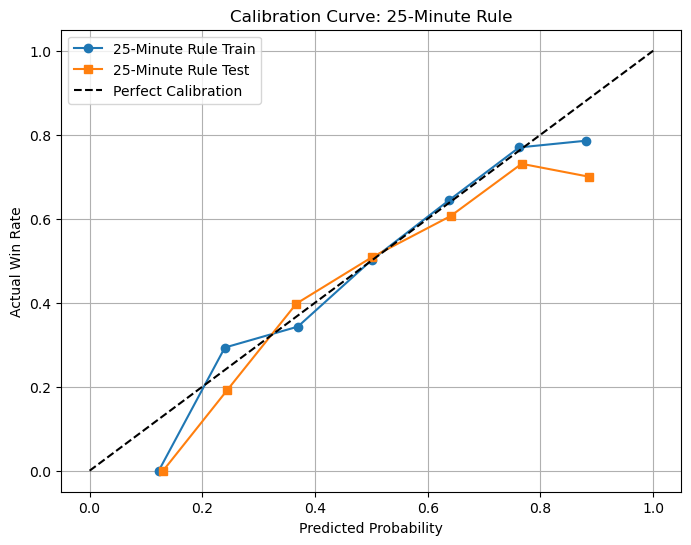

25-Minute Rule - Train set samples per bin:
  Bin 1 ((-0.001, 0.143]): 8 samples
  Bin 2 ((0.143, 0.286]): 208 samples
  Bin 3 ((0.286, 0.429]): 685 samples
  Bin 4 ((0.429, 0.571]): 1077 samples
  Bin 5 ((0.571, 0.714]): 926 samples
  Bin 6 ((0.714, 0.857]): 304 samples
  Bin 7 ((0.857, 1.0]): 14 samples

25-Minute Rule - Test set samples per bin:
  Bin 1 ((-0.001, 0.143]): 2 samples
  Bin 2 ((0.143, 0.286]): 73 samples
  Bin 3 ((0.286, 0.429]): 294 samples
  Bin 4 ((0.429, 0.571]): 466 samples
  Bin 5 ((0.571, 0.714]): 381 samples
  Bin 6 ((0.714, 0.857]): 156 samples
  Bin 7 ((0.857, 1.0]): 10 samples
------------------------------------------------------------


In [52]:
plot_calibration_and_bins(model_25min)

### Fit & Plot model_anymin (usg*min)

In [49]:
model_usg = fit_and_evaluate_logit(
    df,
    injury_vars=['team_1_minutes_missing_usgXminplayed', 'team_2_minutes_missing_usgXminplayed'],
    model_name='Usage x Minutes'
)

Optimization terminated successfully.
         Current function value: 0.647706
         Iterations 5

Usage x Minutes Summary:

                           Logit Regression Results                           
Dep. Variable:             team_1_win   No. Observations:                 3222
Model:                          Logit   Df Residuals:                     3210
Method:                           MLE   Df Model:                           11
Date:                Mon, 21 Jul 2025   Pseudo R-squ.:                 0.06442
Time:                        14:16:18   Log-Likelihood:                -2086.9
converged:                       True   LL-Null:                       -2230.6
Covariance Type:            nonrobust   LLR p-value:                 3.911e-55
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                        

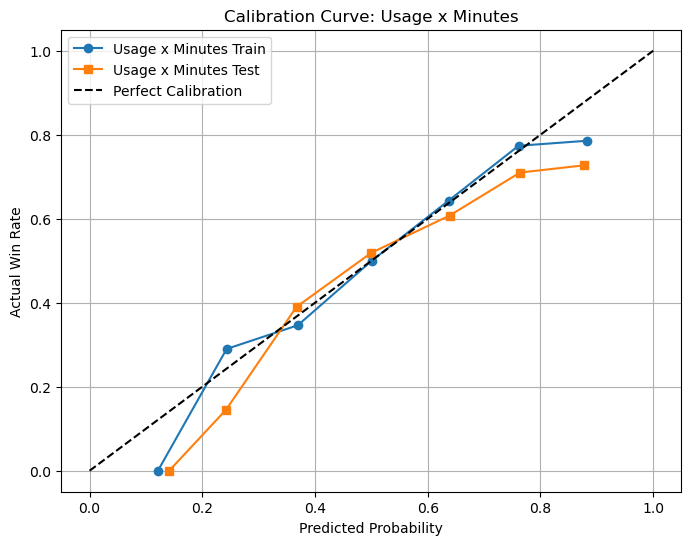

Usage x Minutes - Train set samples per bin:
  Bin 1 ((-0.001, 0.143]): 5 samples
  Bin 2 ((0.143, 0.286]): 200 samples
  Bin 3 ((0.286, 0.429]): 696 samples
  Bin 4 ((0.429, 0.571]): 1081 samples
  Bin 5 ((0.571, 0.714]): 930 samples
  Bin 6 ((0.714, 0.857]): 296 samples
  Bin 7 ((0.857, 1.0]): 14 samples

Usage x Minutes - Test set samples per bin:
  Bin 1 ((-0.001, 0.143]): 1 samples
  Bin 2 ((0.143, 0.286]): 69 samples
  Bin 3 ((0.286, 0.429]): 287 samples
  Bin 4 ((0.429, 0.571]): 480 samples
  Bin 5 ((0.571, 0.714]): 372 samples
  Bin 6 ((0.714, 0.857]): 162 samples
  Bin 7 ((0.857, 1.0]): 11 samples
------------------------------------------------------------


In [53]:
plot_calibration_and_bins(model_usg)

# 🧠 Logistic Regression Model Analysis:

### ⚙️ Model Overview
I evaluated two logistic regression models to predict `team_1_win` in NBA matchups using injury-adjusted features:

- **25-Minute Rule Model**: Includes injury variables based on players missing who averaged ≥25 minutes in 3 of the last 5 games.
- **Usage × Minutes Model**: Includes injury variables based on total usage-weighted minutes lost.

Both models control for offensive and defensive ratings, team possessions, rest days, and home advantage.

---

### 📈 Model Performance: Brier Scores

| Model              | Train Brier Score | Test Brier Score |
|--------------------|------------------|------------------|
| 25-Minute Rule     | 0.2273            | 0.2338           |
| Usage × Minutes    | 0.2280            | 0.2336           |

Brier scores reflect the mean squared error of the predicted probabilities, where lower is better. Both models show reasonably good performance around the 0.23 range, with the Usage × Minutes model having a marginal edge in the test set. However, this difference is negligible in practice.

---

### 🔄 Calibration Curve Analysis

Both models exhibit good calibration, meaning predicted probabilities closely match actual win rates across bins. The 25-Minute Rule model demonstrates slightly smoother calibration and more consistent sample sizes across bins. As expected, extreme bins (near 0 or 1) contain fewer samples.

---

### 📌 Statistically Significant Variables (at 5% level)

| Variable                              | Significant in 25-Min? | Significant in Usage×Min? | Comments |
|--------------------------------------|-------------------------|----------------------------|----------|
| `team_1_off_rating`                  | ✅ p = 0.000             | ✅ p = 0.000                | Expected, strong positive impact |
| `team_2_off_rating`                  | ✅ p = 0.000             | ✅ p = 0.000                | Expected, strong negative impact |
| `team_1_def_rating`                  | ✅ p = 0.000             | ✅ p = 0.000                | Expected, negative impact |
| `team_2_def_rating`                  | ✅ p = 0.000             | ✅ p = 0.000                | Expected, positive impact |
| `team_1_days_rest`                  | ✅ p = 0.017             | ✅ p = 0.012                | Positive and expected |
| `team_2_days_rest`                  | ✅ p = 0.003             | ✅ p = 0.002                | Opponent rest hurts our win chances |
| `home_advantage`                     | ✅ p = 0.000             | ✅ p = 0.000                | Strong and consistent across both models |
| `team_1_minutes_missing_25min_3game` | ✅ p = 0.014             | — N/A                      | Losing key players reduces win chance |
| `team_2_minutes_missing_25min_3game` | ❌ p = 0.062             | — N/A                      | Borderline; potential signal |
| `team_1_minutes_missing_usgXmin`     | — N/A                   | ❌ p = 0.612                | Not significant |
| `team_2_minutes_missing_usgXmin`     | — N/A                   | ❌ p = 0.299                | Not significant |
| `team_1_poss`                        | ❌ p = 0.535             | ❌ p = 0.498                | Not significant |
| `team_2_poss`                        | ❌ p = 0.395             | ❌ p = 0.432                | Not significant |

#### ⚠️ Noteworthy Observations:
- The **Usage × Minutes** injury variables were **insignificant**, which is somewhat surprising given their granularity. This likely indicates excess noise or misalignment in how the metric is constructed.
- The **25-Minute Rule** injury variable for `team_1` was statistically significant at the 2% level, indicating that losing high-minute players meaningfully reduces win probability.
- Possession-based features were insignificant in both models. This was unexpected and may require further review for multicollinearity or low variance.

---

### 📊 Should We Care About R² in Logistic Regression?

No — Pseudo R² is not particularly meaningful in this context.

The reported values (~0.064–0.066) are typical for logistic regression in sports modeling, but they don't capture what we care about most: the quality of probability estimates. Instead, I focused on:

- **Brier Score** – Measures the accuracy of predicted probabilities.
- **Calibration Curves** – Evaluate how well predicted probabilities align with actual outcomes.

These metrics are better suited for evaluating models that predict win probabilities, especially when using them for downstream decision-making or simulations.

---

### 🔧 How I can Improve the Model

1. **Refine Injury Metrics**
   - The 25-Minute Rule showed strong signal for `team_1` and borderline signal for `team_2`. I can experiment with weighting recent games more heavily, incorporating rolling windows, or integrating injury severity.

2. **Improve Roster Feature Engineering**
   - Add context such as **starter status**, **position groupings**, or **player impact estimates** (e.g., EPM, RAPTOR, etc.).

3. **Try Non-Linear Models**
   - Logistic regression may miss interaction effects. I plan to experiment with **tree-based models** like Random Forest or XGBoost, or even **neural networks**, which could uncover deeper patterns.

4. **Filter or Adjust for End-of-Season Anomalies**
   - Late-season NBA games often involve unusual player rotations due to playoff positioning or rest strategies. These could be treated as outliers or modeled separately to avoid distortion.

---

### ✅ Final Verdict

- The **25-Minute Rule model** appears more reliable and interpretable than the Usage × Minutes model.
- It produces a similarly strong Brier score and is supported by a statistically significant injury variable.
- Both models show solid calibration and serve as a great foundation.
- With better injury tracking, expanded feature engineering, and non-linear modeling, I believe performance can be improved further in future iterations.
